<H1><center>Applied Data Science Capstone
    
    Capstone Project

<H3><center>ACCESSING THE POPULATION SIZE, DENSITY AND VENUES INFORMATION OF LAGOS NEIGHBOURHOODS

<b>Introduction</b>

Background<br>
Lagos is a state located in the south-western part of Nigeria. It is the country's most important commercial centre and the focal point of economic activities. Due to the economic prospects of Lagos and other factors, the state is very well populated.
Lagos is the most populous city in Nigeria despite it being the smallest state in the country. Its population accounts for about 27.4% of the national estimate. According to 2016 statistics, Lagos has a population size of 21 million and it is continually growing. It has been estimated that by 2050, its population will have doubled.
The large population of the state compared to its small size has created a problem that some stakeholders have termed as overpopulation. This problem has given rise to another problem - high traffic congestion in the state. While Lagos has population problem, not all parts of it are densely populated. There are 20 Local Government Areas in Lagos. These can be viewed as neighbourhoods for the administration of the state and they have districts under them.

Problem<br>
There is a need to have easy and intuitive means of accessing information about the population density of the different neighbourhoods (Local Government Areas) as well as postal codes and venues information. This project aims to create a visual access to the population distribution of Lagos neighbourhoods including a map that will incorporate the vital information with segmentation and clustering analysis.

Interest<br>
Migrants, travelers, business investors and government will benefit from the ease of access to vital information that this project will provide.
    
<b>Data</b>  
The data for this project was obtained in unstructured format. A table was produced manually from information sourced from official documents and from the internet. The data requirement was divided into four parts based on how they were obtained.
1.	Postal codes of the different neighbourhoods (Local Government Areas);
2.	Lagos State official population data listing the Local Government Areas (neighbourhoods) with their population densities;
3.	Geo-coordinates of all neighbourhoods of Lagos;
4.	Venues information of the different neighbourhoods.


#### Importing all required libraries

In [1]:
import pandas as pd # primary data structure library

import numpy as np  # useful for many scientific computing in Python

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline

import folium # map rendering library

import requests

# import k-means from clustering stage
from sklearn.cluster import KMeans

#### Loading the prepared dataset from github

In [2]:
# Loading prepared dataset from github and assigning it to a variable

data = 'https://raw.githubusercontent.com/femionnet/Coursera_Capstone/master/PrjWk4n5.csv'

In [3]:
# Loading csv file into pandas dataframe
df = pd.read_csv(data)

In [4]:
# Viewing the first 5 rows of the loaded data
df.head()

,Postal Code,Neighbourhoods,Population,Population density,Latitude,Longitude
0,100283,Agege,1415547,60768.47,6.619830,3.322165
1,102103,Ajeromi Ifelodun,1966700,103258.63,6.455480,3.333860
2,100275,Alimosho,2804919,14855.05,6.610556,3.295830
3,102102,Amuwo Odofin,719337,2931.16,6.450000,3.266667
4,102241,Apapa,715792,13568.42,6.449998,3.366665


### Data Visualization

Visually exploring the population density of the Neighbourhoods of Lagos

In [5]:
df_viz = df[['Neighbourhoods', 'Population density']]
df_viz.set_index('Neighbourhoods', inplace = True)
df_viz.head()

,Population density
Neighbourhoods,
Agege,60768.47
Ajeromi Ifelodun,103258.63
Alimosho,14855.05
Amuwo Odofin,2931.16
Apapa,13568.42


Creating a bar chart of population density of Lagos Neighbourhoods

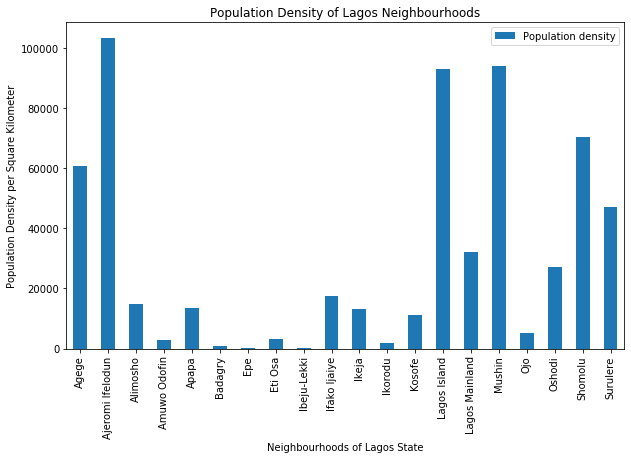

In [6]:
df_viz.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Neighbourhoods of Lagos State') # add to x-label to the plot
plt.ylabel('Population Density per Square Kilometer') # add y-label to the plot
plt.title('Population Density of Lagos Neighbourhoods') # add title to the plot

plt.show()

#### The bar chart shows that not all Neighbourhoods are actually overpopulated, just a few of them

Lets explore this observation using a histogram to view the distribution of the Neighbourhood densities

In [7]:
count, bin_edges = np.histogram(df_viz['Population density'])
print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

[7 5 1 1 1 1 1 0 1 2]
[   152.43  10463.05  20773.67  31084.29  41394.91  51705.53  62016.15
  72326.77  82637.39  92948.01 103258.63]


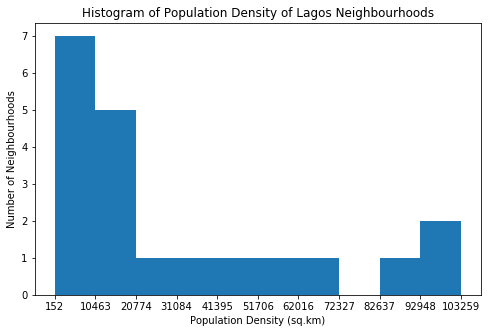

In [8]:
# Creating well formatted xtics using numpy library
count, bin_edges = np.histogram(df_viz['Population density'])

df_viz['Population density'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Histogram of Population Density of Lagos Neighbourhoods') # add a title to the histogram
plt.ylabel('Number of Neighbourhoods') # add y-label
plt.xlabel('Population Density (sq.km)') # add x-label

plt.show()

The population density of the Neighbourhoods are more concentrated on the left side of the histogram than the right side meaning most of the neighbourhoods are actually less dense contrary to what their population size suggests

12 out of 20 Neighbourhoods have population density between 152 sq.km and 20,774 sq.km according to the histogram

This suggests that the few Neighbourhoods with high density are the ones overpopulated. Also, these Neighbourhoods must be major commercial centres of the state to have attracted high influx of people.

#### This observation will be explored further with map visualization and venues data 

Meanwhile...

To get a formatted view of the Population size and density information that will be placed on the map, the respective columns will be reformatted so that values in thousands are separated by comma.

In [9]:
df_format = df.loc[:,]
df_format['Population'] = df_format.loc[:,'Population'].apply('{:,}'.format)
df_format['Population density'] = df_format.loc[:,'Population density'].apply('{:,}'.format)
df_format.head()

,Postal Code,Neighbourhoods,Population,Population density,Latitude,Longitude
0,100283,Agege,"1,415,547","60,768.47",6.619830,3.322165
1,102103,Ajeromi Ifelodun,"1,966,700","103,258.63",6.455480,3.333860
2,100275,Alimosho,"2,804,919","14,855.05",6.610556,3.295830
3,102102,Amuwo Odofin,"719,337","2,931.16",6.450000,3.266667
4,102241,Apapa,"715,792","13,568.42",6.449998,3.366665


With formatting complete, map creation can begin

### Creating a map of Lagos with Neighbourhoods having their respective information

In [10]:
# Generating the coordinates of Lagos using geocoder library

address = 'Lagos, Nigeria'

geolocator = Nominatim(user_agent="ng_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The coordinates of Lagos are {latitude}, {longitude}.')

The coordinates of Lagos are 6.4550575, 3.3941795.


In [11]:
# create map of Lagos using latitude and longitude values
lagos_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, lg, pocode, pop, den in zip(df['Latitude'], df['Longitude'], df['Neighbourhoods'], df['Postal Code'], df_format['Population'], df_format['Population density']):
    label = f'{lg}\nZip:{pocode}\nPopulation: {pop}\nDensity: {den} sq.km'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(lagos_map)  
    
lagos_map

The blue points are the Neighbourhoods and their respective information are displayed upon clicking

#### Generating venues data for the Neighbourhoods

In [12]:
# Foursquare API credentials

CLID = 'FOURSQUARE API CLIENT ID'
CLSCRT = 'FOURSQUARE API CLIENT SECRET'
VERSION = '20200229'

In [13]:
# Script for extracting venues information from Foursquare API response

def getNearbyVenues(names, latitudes, longitudes, radius=2000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLID, 
            CLSCRT, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
# Calling the script on the Neighbourhood coordinates

lagos_venues = getNearbyVenues(names=df['Neighbourhoods'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Agege
Ajeromi Ifelodun
Alimosho
Amuwo Odofin
Apapa
Badagry
Epe
Eti Osa
Ibeju-Lekki
Ifako Ijaiye
Ikeja
Ikorodu
Kosofe
Lagos Island
Lagos Mainland
Mushin
Ojo
Oshodi
Shomolu
Surulere


#### Checking size of the resulting dataframe

In [15]:
print(lagos_venues.shape)

# Viewing the first 5 results
lagos_venues.head()

(234, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agege,6.61983,3.322165,KFC,6.620788,3.317968,Fast Food Restaurant
1,Agege,6.61983,3.322165,Tastee Fried Chicken,6.629090,3.324350,Fast Food Restaurant
2,Agege,6.61983,3.322165,Shoprite Ikeja,6.614340,3.331319,Shopping Mall
3,Agege,6.61983,3.322165,SmartieMart,6.627753,3.337087,Convenience Store
4,Agege,6.61983,3.322165,The Burha,6.626739,3.324065,Fast Food Restaurant


234 venues were returned by the foursquare API for all 20 Neighbourhoods within a radius of 2000 meters. This result is quite low and it suggests that there are not too many venues entry in the Foursquare database for Lagos Neighbourhoods.

#### Viewing the results for each Neighbourhood

In [16]:
lagos_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agege,10,10,10,10,10,10
Ajeromi Ifelodun,4,4,4,4,4,4
Alimosho,11,11,11,11,11,11
Amuwo Odofin,6,6,6,6,6,6
Apapa,9,9,9,9,9,9
Badagry,4,4,4,4,4,4
Epe,1,1,1,1,1,1
Eti Osa,4,4,4,4,4,4
Ibeju-Lekki,6,6,6,6,6,6


#### How many unique categories are in the results

In [17]:
print(f"There are {len(lagos_venues['Venue Category'].unique())} unique categories.")

There are 77 unique categories.


### Analyzing each Neighbourhood with their venues

In [18]:
# one hot encoding
lagos_onehot = pd.get_dummies(lagos_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
lagos_onehot['Neighbourhood'] = lagos_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [lagos_onehot.columns[-1]] + list(lagos_onehot.columns[:-1])
lagos_onehot = lagos_onehot[fixed_columns]

lagos_onehot.head()

,Neighbourhood,African Restaurant,American Restaurant,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,...,Shopping Mall,Snack Place,Soccer Field,Soup Place,Spa,Stadium,Steakhouse,Trail,Vineyard,Wine Shop
0,Agege,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Agege,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Agege,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,Agege,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Agege,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Examining the size of the new dataframe

In [19]:
lagos_onehot.shape

(234, 78)

There are now 78 columns

#### Grouping the rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [20]:
lagos_grouped = lagos_onehot.groupby('Neighbourhood').mean().reset_index()
lagos_grouped

,Neighbourhood,African Restaurant,American Restaurant,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,...,Shopping Mall,Snack Place,Soccer Field,Soup Place,Spa,Stadium,Steakhouse,Trail,Vineyard,Wine Shop
0,Agege,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Ajeromi Ifelodun,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Alimosho,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Amuwo Odofin,0.166667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Apapa,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.222222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Badagry,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Epe,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Eti Osa,0.250000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Ibeju-Lekki,0.166667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Ifako Ijaiye,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.250000,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Checking the new size

In [21]:
lagos_grouped.shape

(20, 78)

#### Viewing each Neighbourhood with their top 5 venues

In [22]:
num_top_venues = 5

for hood in lagos_grouped['Neighbourhood']:
    print("***** "+hood+" *****")
    tmp = lagos_grouped[lagos_grouped['Neighbourhood'] == hood].T.reset_index()
    tmp.columns = ['venue','frequency']
    tmp = tmp.iloc[1:]
    tmp['frequency'] = tmp['frequency'].astype(float)
    tmp = tmp.round({'frequency': 2})
    print(tmp.sort_values('frequency', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

***** Agege *****
                  venue  frequency
0           Bus Station        0.4
1  Fast Food Restaurant        0.3
2         Shopping Mall        0.1
3                Market        0.1
4     Convenience Store        0.1


***** Ajeromi Ifelodun *****
                venue  frequency
0         Bus Station       0.50
1     Harbor / Marina       0.25
2           Rest Area       0.25
3  Photography Studio       0.00
4        Optical Shop       0.00


***** Alimosho *****
                  venue  frequency
0  Fast Food Restaurant       0.18
1           Bus Station       0.18
2                  Park       0.09
3                 Hotel       0.09
4            Campground       0.09


***** Amuwo Odofin *****
                venue  frequency
0               Hotel       0.33
1  African Restaurant       0.17
2   Electronics Store       0.17
3                Park       0.17
4     Harbor / Marina       0.17


***** Apapa *****
               venue  frequency
0      Shopping Mall       0.22
1

#### Sorting the venues in descending order with a function and creating new dataframe showing top 10 venues of Lagos Neighbourhoods

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = lagos_grouped['Neighbourhood']

for ind in np.arange(lagos_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(lagos_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agege,Bus Station,Fast Food Restaurant,Market,Convenience Store,Shopping Mall,Wine Shop,Coffee Shop,Convention Center,Cupcake Shop,Department Store
1,Ajeromi Ifelodun,Bus Station,Harbor / Marina,Rest Area,Chinese Restaurant,Coffee Shop,Convenience Store,Convention Center,Cupcake Shop,Department Store,Diner
2,Alimosho,Bus Station,Fast Food Restaurant,Park,Boutique,Campground,Bus Stop,Hotel,Basketball Court,Mobile Phone Shop,Convention Center
3,Amuwo Odofin,Hotel,Harbor / Marina,Park,Electronics Store,African Restaurant,Spa,Soup Place,Chinese Restaurant,Clothing Store,Coffee Shop
4,Apapa,Shopping Mall,Indian Restaurant,Boat or Ferry,Pier,Pizza Place,Playground,Hotel,Market,Coffee Shop,Convenience Store


## Clustering of Neighbourhoods

Creating 5 clusters and using kmeans clustering

In [25]:
# set number of clusters
kclusters = 5

lagos_grouped_clustering = lagos_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(lagos_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:] 

array([0, 0, 0, 2, 1, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1])

Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [26]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

lagos_merged = df

# merge lagos_grouped with df to add latitude/longitude for each neighbourhood
lagos_merged = lagos_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhoods')

lagos_merged.head() # check the last columns!

,Postal Code,Neighbourhoods,Population,Population density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,100283,Agege,"1,415,547","60,768.47",6.619830,3.322165,0,Bus Station,Fast Food Restaurant,Market,Convenience Store,Shopping Mall,Wine Shop,Coffee Shop,Convention Center,Cupcake Shop,Department Store
1,102103,Ajeromi Ifelodun,"1,966,700","103,258.63",6.455480,3.333860,0,Bus Station,Harbor / Marina,Rest Area,Chinese Restaurant,Coffee Shop,Convenience Store,Convention Center,Cupcake Shop,Department Store,Diner
2,100275,Alimosho,"2,804,919","14,855.05",6.610556,3.295830,0,Bus Station,Fast Food Restaurant,Park,Boutique,Campground,Bus Stop,Hotel,Basketball Court,Mobile Phone Shop,Convention Center
3,102102,Amuwo Odofin,"719,337","2,931.16",6.450000,3.266667,2,Hotel,Harbor / Marina,Park,Electronics Store,African Restaurant,Spa,Soup Place,Chinese Restaurant,Clothing Store,Coffee Shop
4,102241,Apapa,"715,792","13,568.42",6.449998,3.366665,1,Shopping Mall,Indian Restaurant,Boat or Ferry,Pier,Pizza Place,Playground,Hotel,Market,Coffee Shop,Convenience Store


### Visualizing the created clusters on Lagos Map

In [27]:
# create map
lagos_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, pop, den, cluster in zip(lagos_merged['Latitude'], lagos_merged['Longitude'], lagos_merged['Neighbourhoods'], df_format['Population'], df_format['Population density'], lagos_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Population ' + pop + ' P.Density ' + den, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(lagos_map)
       
lagos_map

The map above shows Lagos Neighbourhoods clustered based on the distinct venue categories they have. Also, each Neighbourhood provides rich information relating to Population Size and Density which is accessible by clicking any of the coloured dots on the map.

### Examining the clusters

Determining the distinct characteristics of each cluster based on the venue categories

##### Cluster 1 - Social and Business hub

In [28]:
lagos_merged.loc[lagos_merged['Cluster Labels'] == 0, lagos_merged.columns[[1] + list(range(5, lagos_merged.shape[1]))]]

,Neighbourhoods,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agege,3.322165,0,Bus Station,Fast Food Restaurant,Market,Convenience Store,Shopping Mall,Wine Shop,Coffee Shop,Convention Center,Cupcake Shop,Department Store
1,Ajeromi Ifelodun,3.333860,0,Bus Station,Harbor / Marina,Rest Area,Chinese Restaurant,Coffee Shop,Convenience Store,Convention Center,Cupcake Shop,Department Store,Diner
2,Alimosho,3.295830,0,Bus Station,Fast Food Restaurant,Park,Boutique,Campground,Bus Stop,Hotel,Basketball Court,Mobile Phone Shop,Convention Center


##### Cluster 2 - Hospitality, Trading and Events hub

In [29]:
lagos_merged.loc[lagos_merged['Cluster Labels'] == 1, lagos_merged.columns[[1] + list(range(5, lagos_merged.shape[1]))]]

,Neighbourhoods,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Apapa,3.366665,1,Shopping Mall,Indian Restaurant,Boat or Ferry,Pier,Pizza Place,Playground,Hotel,Market,Coffee Shop,Convenience Store
7,Eti Osa,3.601521,1,African Restaurant,Fast Food Restaurant,Nature Preserve,Lounge,Food Court,Food & Drink Shop,Food,Flea Market,Food Truck,Chinese Restaurant
8,Ibeju-Lekki,3.596457,1,Bar,African Restaurant,Beer Garden,Gym / Fitness Center,Rest Area,Convenience Store,Convention Center,Cupcake Shop,Department Store,Diner
9,Ifako Ijaiye,3.288889,1,Gym,Soccer Field,Snack Place,Shopping Mall,Wine Shop,Diner,Clothing Store,Coffee Shop,Convenience Store,Convention Center
10,Ikeja,3.349149,1,Hotel,Fast Food Restaurant,Shopping Mall,African Restaurant,Pizza Place,Lounge,Mobile Phone Shop,Liquor Store,Multiplex,Indian Restaurant
11,Ikorodu,3.508072,1,African Restaurant,Historic Site,Auto Workshop,Café,Bus Station,Bar,Electronics Store,Fast Food Restaurant,Convention Center,Cupcake Shop
12,Kosofe,3.384247,1,Shopping Mall,Department Store,Bar,Convenience Store,Fast Food Restaurant,Lounge,Park,Pizza Place,Hotel,Plaza
13,Lagos Island,3.399998,1,Fast Food Restaurant,Shopping Mall,Market,Hotel,Harbor / Marina,Photography Studio,Park,Music Venue,Lounge,Fried Chicken Joint
14,Lagos Mainland,3.384247,1,Fast Food Restaurant,Nightclub,Shopping Mall,Bus Station,African Restaurant,Boutique,Food & Drink Shop,Ice Cream Shop,Department Store,Cupcake Shop
15,Mushin,3.349999,1,Flea Market,Fast Food Restaurant,Department Store,Vineyard,Music Venue,Convenience Store,Bus Station,Burger Joint,Rental Car Location,Wine Shop


##### Cluster 3 - Hospitality and Business hub

In [30]:
lagos_merged.loc[lagos_merged['Cluster Labels'] == 2, lagos_merged.columns[[1] + list(range(5, lagos_merged.shape[1]))]]

,Neighbourhoods,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Amuwo Odofin,3.266667,2,Hotel,Harbor / Marina,Park,Electronics Store,African Restaurant,Spa,Soup Place,Chinese Restaurant,Clothing Store,Coffee Shop
16,Ojo,3.183333,2,Park,American Restaurant,Hotel,Food,Pub,Diner,Clothing Store,Coffee Shop,Convenience Store,Convention Center


##### Cluster 4 - Business hub and Eatries

In [31]:
lagos_merged.loc[lagos_merged['Cluster Labels'] == 3, lagos_merged.columns[[1] + list(range(5, lagos_merged.shape[1]))]]

,Neighbourhoods,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Epe,3.983329,3,Hotel,Wine Shop,Fast Food Restaurant,Coffee Shop,Convenience Store,Convention Center,Cupcake Shop,Department Store,Diner,Electronics Store


##### Cluster 5 - Historical centre

In [32]:
lagos_merged.loc[lagos_merged['Cluster Labels'] == 4, lagos_merged.columns[[1] + list(range(5, lagos_merged.shape[1]))]]

,Neighbourhoods,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Badagry,2.8833,4,History Museum,Beer Garden,Museum,Wine Shop,Coffee Shop,Convenience Store,Convention Center,Cupcake Shop,Department Store,Diner
